# Structural analysis

## Detection of disulfide bonds

This function detects disulfide bridges in protein structures. Then the detected disulfide bonds are visualized and added to the bonds attribute of the AtomArray.,

The employed criteria for disulfide bonds are quite simple in this case: the atoms of two cystein residues must be in a vicinity of Å and the dihedral angle of must be .

In [1]:
# Code source: Patrick Kunzmann
# License: BSD 3 clause

from tempfile import gettempdir
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import biotite.sequence as seq
import biotite.structure as struc
import biotite.structure.io as strucio
import biotite.structure.io.mmtf as mmtf
import biotite.database.rcsb as rcsb
import biotite.structure.io.pdb as pdb
%config InlineBackend.figure_format = 'retina' 

# Fetch and load structure
pdb_file = pdb.PDBFile.read("../data/structure.pdb")
array = pdb_file.get_structure(model=1)

def detect_disulfide_bonds(structure, distance=2.05, distance_tol=0.05,
                           dihedral=90, dihedral_tol=10):
    # Array where detected disulfide bonds are stored
    disulfide_bonds = []
    # A mask that selects only S-gamma atoms of cysteins
    sulfide_mask = (structure.res_name == "CYS") & \
                   (structure.atom_name == "SG")
    # sulfides in adjacency to other sulfides are detected in an
    # efficient manner via a cell list
    cell_list = struc.CellList(
        structure,
        cell_size=distance+distance_tol,
        selection=sulfide_mask
    )
    # Iterate over every index corresponding to an S-gamma atom
    for sulfide_i in np.where(sulfide_mask)[0]:
        # Find indices corresponding to other S-gamma atoms,
        # that are adjacent to the position of structure[sulfide_i]
        # We use the faster 'get_atoms_in_cells()' instead of
        # `get_atoms()`, as precise distance measurement is done
        # afterwards anyway
        potential_bond_partner_indices = cell_list.get_atoms_in_cells(
            coord=structure.coord[sulfide_i]
        )
        # Iterate over every index corresponding to an S-gamma atom
        # as bond partner
        for sulfide_j in potential_bond_partner_indices:
            if sulfide_i == sulfide_j:
                # A sulfide cannot create a bond with itself:
                continue
            # Create 'Atom' instances
            # of the potentially bonds S-gamma atoms
            sg1 = structure[sulfide_i]
            sg2 = structure[sulfide_j]
            # For dihedral angle measurement the corresponding
            # C-beta atoms are required, too
            cb1 = structure[
                (structure.chain_id == sg1.chain_id) &
                (structure.res_id == sg1.res_id) &
                (structure.atom_name == "CB")
            ]
            cb2 = structure[
                (structure.chain_id == sg2.chain_id) &
                (structure.res_id == sg2.res_id) &
                (structure.atom_name == "CB")
            ]
            # Measure distance and dihedral angle and check criteria
            bond_dist = struc.distance(sg1, sg2)
            bond_dihed = np.abs(np.rad2deg(struc.dihedral(cb1, sg1, sg2, cb2)))
            if bond_dist  > distance - distance_tol and \
               bond_dist  < distance + distance_tol and \
               bond_dihed > dihedral - dihedral_tol and \
               bond_dihed < dihedral + dihedral_tol:
                    # Atom meet criteria -> we found a disulfide bond
                    # -> the indices of the bond S-gamma atoms
                    # are put into a tuple with the lower index first
                    bond_tuple = sorted((sulfide_i, sulfide_j))
                    # Add bond to list of bonds, but each bond only once
                    if bond_tuple not in disulfide_bonds:
                        disulfide_bonds.append(bond_tuple)
    return np.array(disulfide_bonds, dtype=int)

# mmtf_file = mmtf.MMTFFile.read(
#     rcsb.fetch("2IT7", "mmtf", gettempdir())
# )
# pdb_file = pdb.PDBFile.read("../data/predict_aflibercept.pdb")
knottin = pdb_file.get_structure(include_bonds=True, model=1)
# knottin = mmtf.get_structure(mmtf_file, include_bonds=True, model=1)

sulfide_indices = np.where((knottin.res_name == "CYS") & (knottin.atom_name == "SG"))[0]
for i, j, _ in knottin.bonds.as_array():
    if i in sulfide_indices and j in sulfide_indices:
        print(knottin[i])
        print(knottin[j])
        knottin.bonds.remove_bond(i,j)

disulfide_bonds = detect_disulfide_bonds(knottin)
for sg1_index, sg2_index in disulfide_bonds:
    print(knottin[sg1_index])
    print(knottin[sg2_index])

    A     171  CYS SG     S        16.601   32.190  143.334
    A     184  CYS SG     S        18.540   32.510  142.815
    A     422  CYS SG     S        26.896   13.750  106.306
    A     432  CYS SG     S        27.418   11.787  106.401
    A     422  CYS SG     S        26.896   13.750  106.306
    A     432  CYS SG     S        27.418   11.787  106.401


The found disulfide bonds are visualized with the help of Matplotlib: The amino acid sequence is written on the X-axis and the disulfide bonds are depicted by yellow semi-ellipses.


In [2]:
# # Create a sequence object for each residue in the structure
# # As we want each residue to appear only once in the sequence,
# # we choose an atom that appears in each residue once: the CA
# sequence = seq.ProteinSequence(knottin.res_name[knottin.atom_name == "CA"])
# figure = plt.figure(figsize=(12, 4))
# ax = figure.gca()
# MARGIN = 0.2

# ax.set_ylim(0, 1+MARGIN)
# ax.set_xticks(np.arange(1, len(sequence)+1))
# ax.set_xticklabels(str(sequence))
# ax.set_xlim(knottin.res_id[sg1_index]-10, knottin.res_id[sg2_index]+10) # hard coding for sequence margin
# ax.yaxis.set_tick_params(
#     left=False, right=False, labelleft=False, labelright=False
# )
# ax.xaxis.set_tick_params(
#     bottom=True, top=False, labelbottom=True, labeltop=False, width=0
# )
# ax.set_frame_on(False)
# for sg1_index, sg2_index in disulfide_bonds:
#     sg1_res_id = knottin.res_id[sg1_index]
#     sg2_res_id = knottin.res_id[sg2_index]
#     ellipse_center = (sg1_res_id + sg2_res_id) / 2
#     ellipse_width = sg2_res_id - sg1_res_id
#     # Height is 2 instead of 1,
#     # because only the upper half of the ellipse is visible
#     ax.add_patch(patches.Ellipse(
#         xy=(ellipse_center, 0), width=ellipse_width, height=2,
#         facecolor="None", edgecolor="gold", linewidth=2
#     ))
# figure.tight_layout()

## Calculation of protein diameter

This calculates the diameter of a protein defined as the maximum pairwise atom distance.

In [3]:
# Code source: Patrick Kunzmann
# License: BSD 3 clause

from Bio import SeqIO
from tempfile import gettempdir
import numpy as np
import biotite.structure as struc
import biotite.structure.io as strucio
import biotite.database.rcsb as rcsb

record = SeqIO.read("../data/sequence.fasta", "fasta")
target_name = record.name

def get_diameter(pdb_array):
    atom_array = pdb_array
    # Remove all non-amino acids
    atom_array = atom_array[struc.filter_amino_acids(atom_array)]
    coord = atom_array.coord
    # Calculate all pairwise difference vectors
    diff = coord[:, np.newaxis, :] - coord[np.newaxis, :, :]
    # Calculate absolute of difference vectors -> square distances
    sq_dist = np.sum(diff*diff, axis=-1)
    # Maximum distance is diameter
    diameter = np.sqrt(np.max(sq_dist))
    return diameter

# Example application
diameter = get_diameter(array)
print(f"Diameter of {target_name} is: {diameter:.3f} Angstrom.")

Diameter of Idursulfasebeta is: 71.274 Angstrom.


## Ramachandran plot

This creates a Ramachandran plot of the motor domain of target protein.

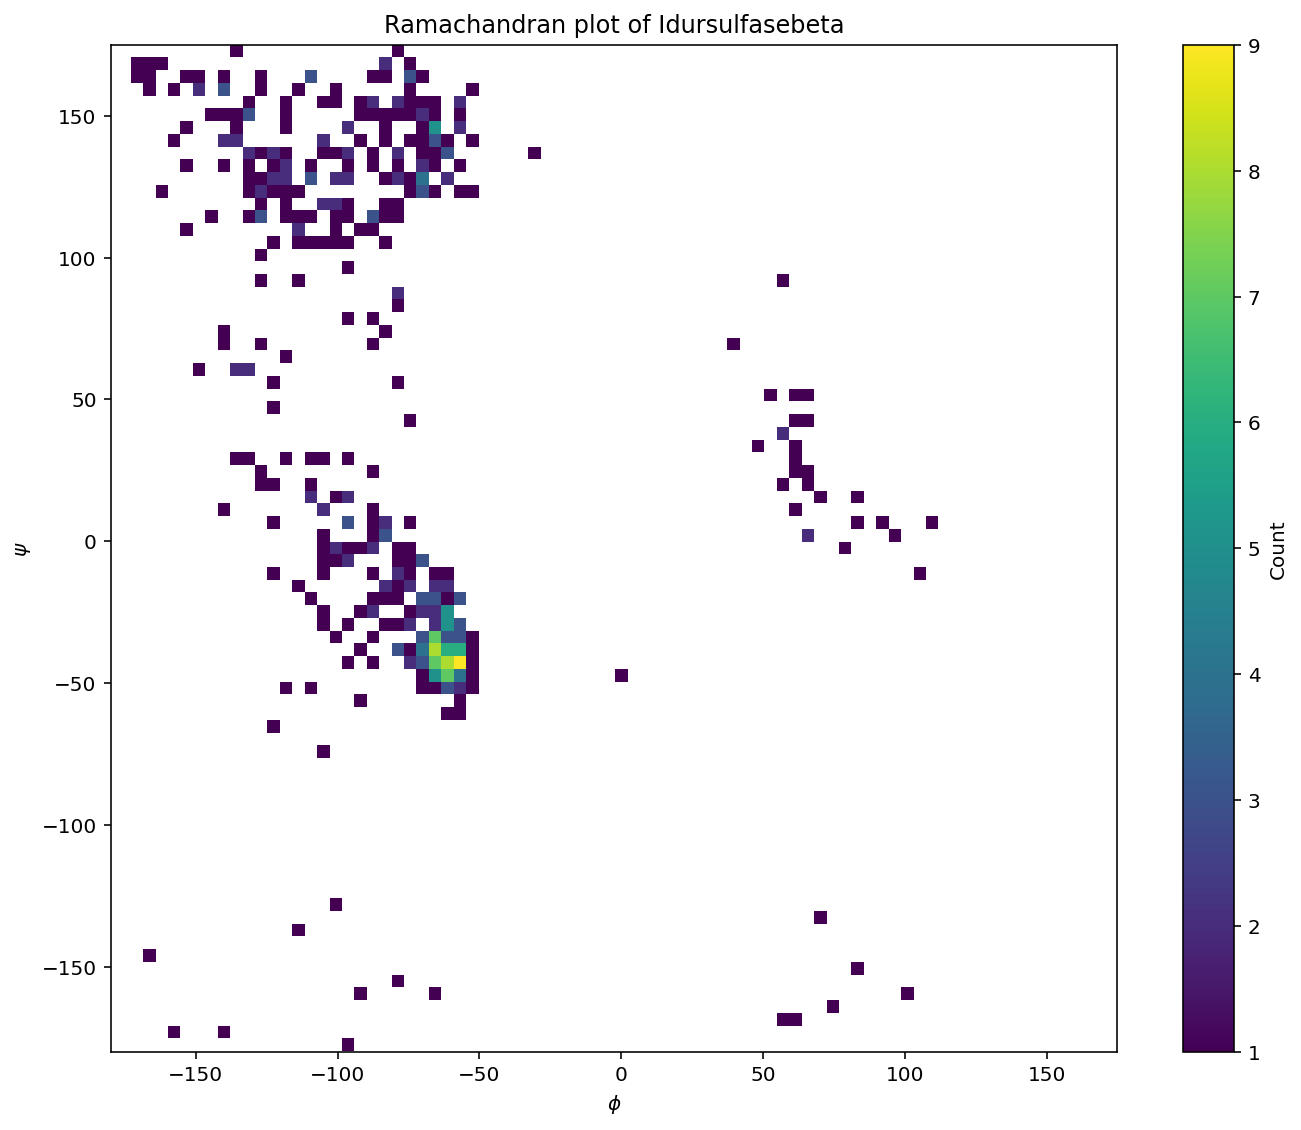

In [4]:
# Code source: Patrick Kunzmann
# License: BSD 3 clause

from tempfile import gettempdir
import biotite.structure as struc
import biotite.structure.io as strucio
import biotite.database.rcsb as rcsb
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
import scipy.stats as sts

atom_array = array
# Calculate backbone dihedral angles
# from one of the two identical chains in the asymmetric unit
phi, psi, omega = struc.dihedral_backbone(
    atom_array[atom_array.chain_id == "A"]
)
# Conversion from radians into degree
phi *= 180/np.pi
psi *= 180/np.pi
# Remove invalid values (NaN) at first and last position
phi= phi[1:-1]
psi= psi[1:-1]

# Plot density
figure = plt.figure(figsize=(10, 8))
ax = figure.add_subplot(111)
h, xed, yed, image = ax.hist2d(phi, psi, bins=(80, 80), cmin=1)
cbar = figure.colorbar(image, orientation="vertical")
cbar.set_label("Count")
ax.set_aspect("equal")
ax.set_xlim(-180, 175)
ax.set_ylim(-180, 175)
ax.set_xlabel(r"$\phi$")
ax.set_ylabel(r"$\psi$")
ax.set_title(f"Ramachandran plot of {target_name}")
figure.tight_layout()
plt.show()
